# Overview
The main focus of this notebook is to test the use of ChatGPT in generating labeled data, that will then be used to train a smaller model, such as BERT.

In [1]:
import os
import pandas as pd
import base64
import mimetypes
from openai import OpenAI
from dotenv import load_dotenv
from IPython.display import Image, display

# API key

In [2]:
load_dotenv()

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Simple test

In [3]:
response = client.chat.completions.create(
    messages=[
        {"role": "system", "content": "You are a geography expert."},
        {"role": "user", "content": "What is the capital of Uruguay?"}
    ],
    model="gpt-4",
)

response_content = response.choices[0].message.content

print(response_content)

The capital of Uruguay is Montevideo.


# Labels

In [5]:
ner_tags = ["N/A", "PRODUCT", "PRICE"]

# First approach (text only)
Here, I will be using phone screen views in a csv format, that are flattened XML trees obtained using Android Accessibility API. The first approach will consist of coalescing all of the text fields from one application and point in time into a single string. It should be noted that in one text filed there could be multiple entities that need to be labeled, so, in the general case, we shouldn't label csv rows.

In [13]:
coupon_df = pd.read_csv("data/18929485529.csv")
coupon_df.head()

,ID,User ID,Time,I,Language,Application Name,Package Name,Class Name,Context,View ID,View Depth,View Class Name,Text,Description,Seen Timestamp,Is Visible,X 1,Y 1,X 2,Y 2
0,18929485529,165559,2024-09-04T10:55:25.287,1,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,0,de.penny.app.main.view.MainActivity,NaN,NaN,0,False,0,0,0,0
1,18929485529,165559,2024-09-04T10:55:25.287,2,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,android:id/content,2,android.widget.FrameLayout,NaN,NaN,1725440082464,True,0,0,1080,2400
2,18929485529,165559,2024-09-04T10:55:25.287,3,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 14.99,NaN,1725440082464,True,339,833,498,874
3,18929485529,165559,2024-09-04T10:55:25.287,4,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,9.99,NaN,1725440082464,True,356,884,482,960
4,18929485529,165559,2024-09-04T10:55:25.287,5,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440082464,True,63,986,125,1027


# Preprocessing

In [6]:
grouping_columns = ['Application Name', 'Seen Timestamp']
grouped_dfs = [group for _, group in coupon_df.groupby(grouping_columns)]
view_texts_coalesced = [" ".join(df['Text'].dropna()) for df in grouped_dfs]

print(view_texts_coalesced)

['', 'UVP 14.99 9.99 UVP JOHNNIE WALKER Red Label Blended Scotch je 0,7 I UVP 0.99 0.75 UVP SAN MIGUEL Especial je 0,5 I UVP 2.99 2.79 UVP FELIX Knabber Mix je 200 g 3.89 Preisknaller FELIX So gut wie es aussieht in Gelee je 12 x 85 g Sparen auf Top-Marken ab 05.09. bis 07.09. Angebote Vorteile Einkaufsliste Vorteilscode Mein PENNY', 'UVP 14.99 9.99 UVP JOHNNIE WALKER Red Label Blended Scotch je 0,7 I UVP 0.99 0.75 UVP SAN MIGUEL Especial je 0,5 I', 'UVP 14.99 9.99 UVP JOHNNIE WALKER Red Label Blended Scotch je 0,7 I UVP 0.99 0.75 UVP SAN MIGUEL Especial je 0,5 I UVP 2.99 2.79 UVP FELIX Knabber Mix je 200 g 3.89 Preisknaller FELIX So gut wie es aussieht in Gelee je 12 x 85 g Framstag ab 06.09. bis 07.09.', 'UVP 2.99 2.79 UVP FELIX Knabber Mix je 200 g 3.89 Preisknaller FELIX So gut wie es aussieht in Gelee je 12 x 85 g Framstag ab 06.09. bis 07.09. UVP 8.99 5.85 UVP CHANTRÉ Weinbrand je 0,7 I', 'Framstag ab 06.09. bis 07.09. UVP 8.99 5.85 UVP CHANTRÉ Weinbrand je 0,7 I 2.79 2.49 1.09 0

# Inference

In [7]:
def text_only_labeling(text, tags):
    prompt = f"""
    You are an NER tagging assistant. Your task is to label all entities in the text based on the tags provided.
    Here are the tags: {', '.join(tags)}

    For each entity, return the entity and its tag.

    Input text: "{text}"

    Respond with the entities in this JSON format:
    [
        {{ "entity": str, "tag": str }},
        ...
    ]
    """
    
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="gpt-4",
        temperature=0
    )

    return response.choices[0].message.content

print(text_only_labeling(view_texts_coalesced[1], ner_tags))

[
    { "entity": "UVP 14.99 9.99 UVP", "tag": "PRICE" },
    { "entity": "JOHNNIE WALKER Red Label Blended Scotch", "tag": "PRODUCT" },
    { "entity": "je 0,7 I UVP 0.99 0.75 UVP", "tag": "PRICE" },
    { "entity": "SAN MIGUEL Especial", "tag": "PRODUCT" },
    { "entity": "je 0,5 I UVP 2.99 2.79 UVP", "tag": "PRICE" },
    { "entity": "FELIX Knabber Mix", "tag": "PRODUCT" },
    { "entity": "je 200 g 3.89 Preisknaller", "tag": "PRICE" },
    { "entity": "FELIX So gut wie es aussieht in Gelee", "tag": "PRODUCT" },
    { "entity": "je 12 x 85 g", "tag": "PRICE" },
    { "entity": "Sparen auf Top-Marken ab 05.09. bis 07.09.", "tag": "N/A" },
    { "entity": "Angebote Vorteile Einkaufsliste Vorteilscode Mein PENNY", "tag": "N/A" }
]


There are some issues. The weight is being labeled as a price, so let's try adding it as a label.

In [8]:
ner_tags_extended = ner_tags + ["WEIGHT"]

print(text_only_labeling(view_texts_coalesced[1], ner_tags_extended))

[
    { "entity": "UVP 14.99 9.99 UVP", "tag": "PRICE" },
    { "entity": "JOHNNIE WALKER Red Label Blended Scotch", "tag": "PRODUCT" },
    { "entity": "0,7 I", "tag": "WEIGHT" },
    { "entity": "UVP 0.99 0.75 UVP", "tag": "PRICE" },
    { "entity": "SAN MIGUEL Especial", "tag": "PRODUCT" },
    { "entity": "0,5 I", "tag": "WEIGHT" },
    { "entity": "UVP 2.99 2.79 UVP", "tag": "PRICE" },
    { "entity": "FELIX Knabber Mix", "tag": "PRODUCT" },
    { "entity": "200 g", "tag": "WEIGHT" },
    { "entity": "3.89", "tag": "PRICE" },
    { "entity": "FELIX So gut wie es aussieht in Gelee", "tag": "PRODUCT" },
    { "entity": "12 x 85 g", "tag": "WEIGHT" },
    { "entity": "05.09. bis 07.09.", "tag": "N/A" },
    { "entity": "Angebote Vorteile Einkaufsliste Vorteilscode Mein PENNY", "tag": "N/A" }
]


That seems to have solved the issue. As can be seen, two prices are being extracted as one entity, but that could be easily fixed in postprocessing. Let's try a different part of the dataset.

In [9]:
print(text_only_labeling(view_texts_coalesced[6], ner_tags_extended))

[
    { "entity": "UVP 8.99 5.85 UVP", "tag": "PRICE" },
    { "entity": "CHANTRÉ Weinbrand", "tag": "PRODUCT" },
    { "entity": "0,7 I", "tag": "WEIGHT" },
    { "entity": "2.79 2.49", "tag": "PRICE" },
    { "entity": "10% gespart", "tag": "N/A" },
    { "entity": "PENNY Gouda-Scheiben", "tag": "PRODUCT" },
    { "entity": "je 400 g", "tag": "WEIGHT" },
    { "entity": "1.09 0.69", "tag": "PRICE" },
    { "entity": "36% gespart", "tag": "N/A" },
    { "entity": "KINDER Überraschungs-Ei", "tag": "PRODUCT" },
    { "entity": "je 20 g", "tag": "WEIGHT" },
    { "entity": "Framstag ab 06.09. bis 07.09.", "tag": "N/A" }
]


# Second approach (image only)
The second approach will be based on extracting text data straight from an image.

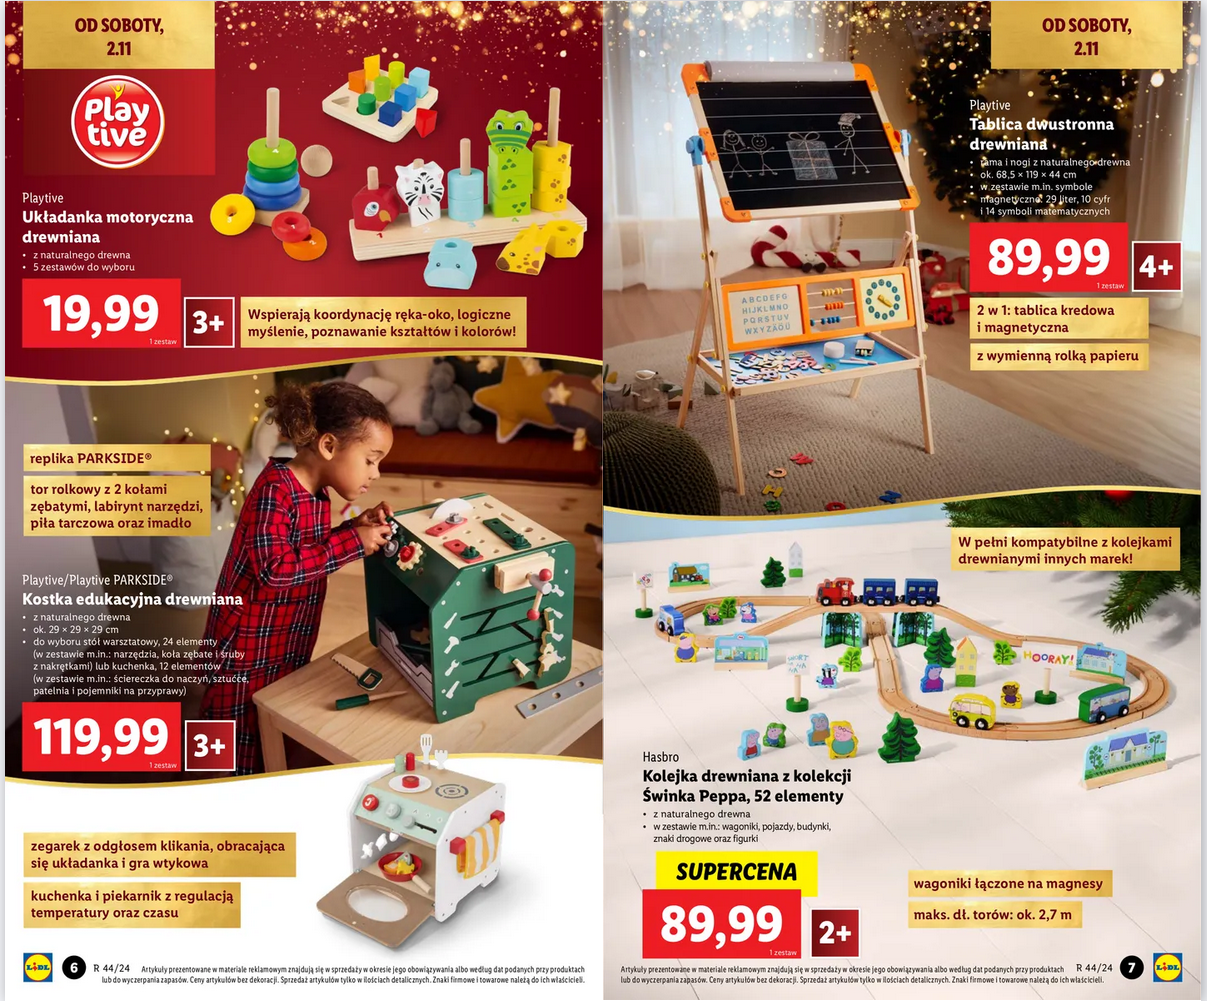

In [3]:
image_path = "data/Screenshot from 2024-11-10 18-13-40.png"

img_type = mimetypes.guess_type(image_path)[0]

with open(image_path, "rb") as img_file:
    img_b64_str = base64.b64encode(img_file.read()).decode("utf-8")

test_img_url = f"data:{img_type};base64,{img_b64_str}"

display(Image(filename=image_path))

# Inference

In [8]:
def image_only_labeling(image_url, tags):
    prompt = f"""
    You are an NER tagging assistant. Your task is to extract and label entities in the given image based on the tags provided.
    It is imperative that you label all of the text that you extract from the image.
    Here are the tags: {', '.join(tags)}

    For each entity, return the entity and its tag.
    
    Respond with the entities in this JSON format:
    [
        {{ "entity": str, "tag": str }},
        ...
    ]
    """
    
    response = client.chat.completions.create(
        messages=[{"role": "user", 
                   "content": [
                       {"type": "text", "text": prompt},
                       {
                           "type": "image_url",
                           "image_url": {"url": image_url},
                       },
                   ],
                  }],
        model="gpt-4o-mini",
    )

    return response.choices[0].message.content



print(image_only_labeling(test_img_url, ner_tags))

```json
[
    { "entity": "Playtive", "tag": "N/A" },
    { "entity": "Układanka motoryczna drewniana", "tag": "PRODUCT" },
    { "entity": "19,99", "tag": "PRICE" },
    { "entity": "3+", "tag": "N/A" },
    { "entity": "PARKSIDE", "tag": "N/A" },
    { "entity": "Kostka edukacyjna drewniana", "tag": "PRODUCT" },
    { "entity": "119,99", "tag": "PRICE" },
    { "entity": "3+", "tag": "N/A" },
    { "entity": "Tablica dwustronna drewniana", "tag": "PRODUCT" },
    { "entity": "89,99", "tag": "PRICE" },
    { "entity": "4+", "tag": "N/A" },
    { "entity": "Hasbro", "tag": "N/A" },
    { "entity": "Kolejka drewniana z kolekcji Świnka Peppa", "tag": "PRODUCT" },
    { "entity": "89,99", "tag": "PRICE" },
    { "entity": "2+", "tag": "N/A" }
]
```


JSON outputting would need to be fixed here.

# Third approach (text + image)
DOZRO: We could ask chat to label the string as in the first approach and pass an image as a hint, but we would need better data to test that. 

# Conclusion
If we are to use Android Accessibility API obtained data to query the mobile phone deployed model, the first approach could yield results that are more similar to the data that the model will encounter "in the wild", but the second approach has the advantage of being potentially easier to utilize.